# Simulating Stellar Clusters with Brown Dwarfs

#### Importing Necessary Packages

In [1]:
# Import necessary packages. 
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity
import numpy as np
import pandas as pd
import pylab as py
from scipy.interpolate import RegularGridInterpolator
import pdb
import matplotlib.pyplot as plt
from astropy.table import vstack
%matplotlib inline

## Case 1: Cluster Without Companions

For this stellar cluster, we will be using the MergedBaraffePisaEkstromParsec evolution model, IMFR_Raithel18 initial-final mass relation, and the Weidner_Kroupa_2004 initial mass function, all of which have been modified to describe substellar masses.

In [2]:
# Create isochrone object  
filt_list = ['wfc3,ir,f153m'] # We won't be doing much with synthetic photometry here, so only need 1 filter
my_ifmr = ifmr.IFMR_Raithel18()
my_iso = synthetic.IsochronePhot(8, 0, 10,
                                 evo_model = evolution.MergedBaraffePisaEkstromParsec(),  #our new evolution model for BDs
                                      filters=filt_list)


In [3]:
# Create IMF objects 
k_imf = imf.Weidner_Kroupa_2004()

In [4]:
# Make cluster
cluster_mass = 10**6
k_cluster = synthetic.ResolvedCluster(my_iso, k_imf, cluster_mass, ifmr=my_ifmr)

# Get outputs
k_out = k_cluster.star_systems

/opt/mambaforge3/envs/astro/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/mambaforge3/envs/astro/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


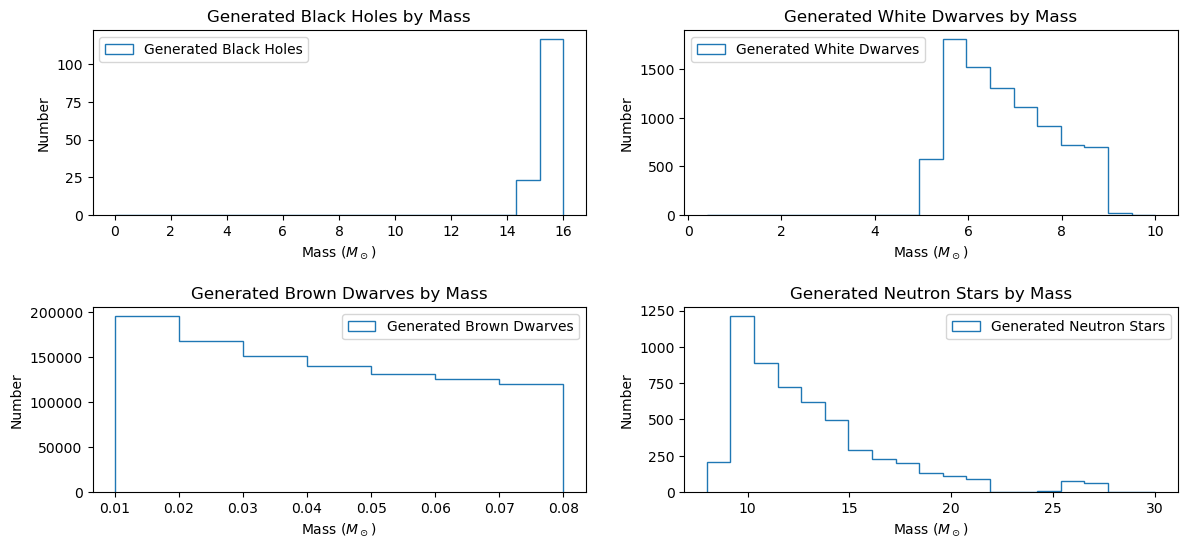

In [5]:
# Locate BHs, NSs, WDs, and BDs
p_bh = np.where(k_out['phase'] == 103)[0]
p_ns = np.where(k_out['phase'] == 102)[0]
p_wd = np.where(k_out['phase'] == 101)[0]
p_bd = np.where(k_out['phase'] == 99)[0]

# Determine individual histogram bins
bh_bins = np.linspace(0.01, 16, 20)
wd_bins = np.linspace(0.4, 10, 20)
bd_bins = np.linspace(0.01, 0.08, 8)
ns_bins = np.linspace(8, 30, 20)

# Plot BHs
plt.figure(figsize=(14,6))
plt.subplot(2, 2, 1)
plt.hist(k_out[p_bh]['mass'], histtype = 'step',
        bins = bh_bins, label = 'Generated Black Holes')
plt.title("Generated Black Holes by Mass")
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

# Plot WDs
plt.subplot(2, 2, 2)
plt.hist(k_out[p_wd]['mass'], histtype = 'step',
        bins = wd_bins, label = 'Generated White Dwarves')
plt.title("Generated White Dwarves by Mass")
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

# Plot BDs
plt.subplot(2, 2, 3)
plt.hist(k_out[p_bd]['mass'], histtype = 'step',
        bins = bd_bins, label = 'Generated Brown Dwarves')
plt.title("Generated Brown Dwarves by Mass")
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

# Plot NSs
plt.subplot(2, 2, 4)
plt.hist(k_out[p_ns]['mass'], histtype = 'step',
        bins = ns_bins, label = 'Generated Neutron Stars')
plt.title("Generated Neutron Stars by Mass")
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

# Adjust space between subplots
plt.subplots_adjust(hspace=0.5)

plt.show()

In [6]:
# Checking that objects are in the correct mass ranges
print("BH max mass: " + str(np.max(k_out[p_bh]['mass'])))
print("BH min mass: " + str(np.min(k_out[p_bh]['mass'])) + '\n')

print("NS max mass: " + str(np.max(k_out[p_ns]['mass'])))
print("NS min mass: " + str(np.min(k_out[p_ns]['mass'])) + '\n')

print("WD max mass: " + str(np.max(k_out[p_wd]['mass'])))
print("WD min mass: " + str(np.min(k_out[p_wd]['mass'])) + '\n')

print("BD max mass: " + str(np.max(k_out[p_bd]['mass'])))
print("BD min mass: " + str(np.min(k_out[p_bd]['mass'])) + '\n')

BH max mass: 119.13565618748322
BH min mass: 15.007725869985796

NS max mass: 119.95876844996108
NS min mass: 9.001129278483436

WD max mass: 8.999341744945873
WD min mass: 5.311091008003858

BD max mass: 0.07999986295473586
BD min mass: 0.010000044934131811



In [7]:
print(k_out[p_bd]['Teff'])

       Teff       
------------------
 653.0891938350937
 651.8458273479349
 707.4325441828001
488.01700684829456
 871.6562359235475
 407.9503554901987
 930.6014364016501
               ...
392.28042415955446
 908.5461410822766
 1393.091834142745
 998.2260271590488
  665.474820549251
 675.9825874832916
1122.0753000795612
Length = 1028848 rows


It is worth noting [explain about big NS's after confirmation from Matt] ..... 
white dwarfs capped at low end due to age of cluster

## Case 2: Cluster With Companions

For this cluster we are using the same isochrone as the one generated in Case 1, just changing our IMF to allow for systems with companions.

In [8]:
# Create IMF objects                                                                                                                                                     
imf_multi = multiplicity.MultiplicityUnresolved()
kc_imf = imf.Weidner_Kroupa_2004(multiplicity=imf_multi)

In [9]:
# Make cluster
cluster_mass = 10**6
kc_cluster = synthetic.ResolvedCluster(my_iso, kc_imf, cluster_mass, ifmr=my_ifmr)

# Get outputs
kc_out = kc_cluster.star_systems
kc_comp = kc_cluster.companions

/opt/mambaforge3/envs/astro/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/mambaforge3/envs/astro/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Found 7301 companions out of stellar mass range


/opt/mambaforge3/envs/astro/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/mambaforge3/envs/astro/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


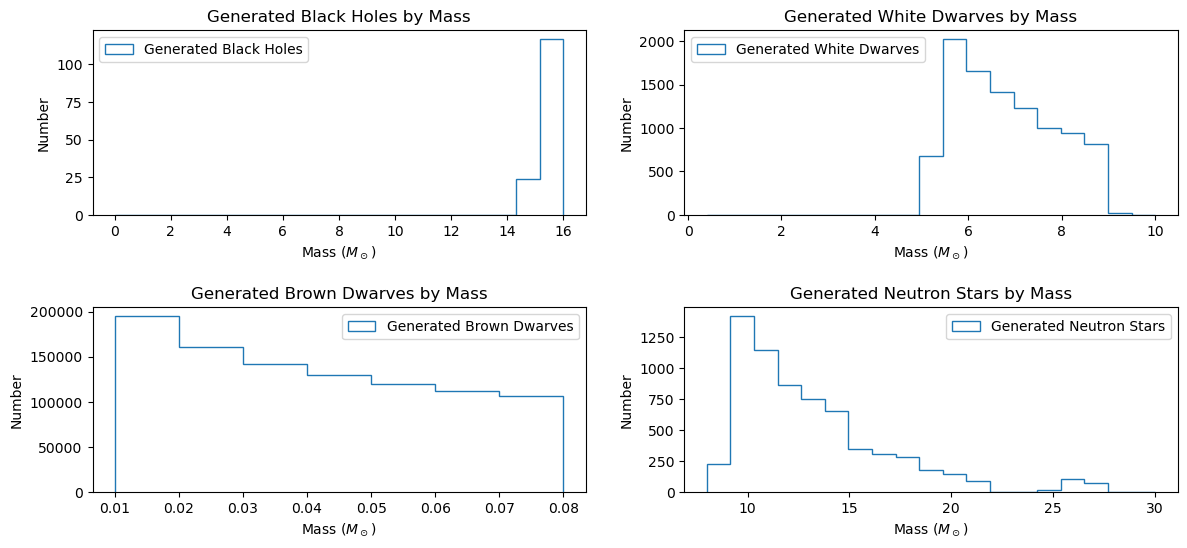

In [10]:
# Locate BHs, NSs, WDs, and BDs
p2_bh = np.where(kc_out['phase'] == 103)[0]
c_bh = np.where(kc_comp['phase'] == 103)[0]
k_bh = vstack([kc_out[p2_bh], kc_comp[c_bh]])
p2_ns = np.where(kc_out['phase'] == 102)[0]
c_ns = np.where(kc_comp['phase'] == 102)[0]
k_ns = vstack([kc_out[p2_ns], kc_comp[c_ns]])
p2_wd = np.where(kc_out['phase'] == 101)[0]
c_wd = np.where(kc_comp['phase'] == 101)[0]
k_wd = vstack([kc_out[p2_wd], kc_comp[c_wd]])
p2_bd = np.where(kc_out['phase'] == 99)[0]
c_bd = np.where(kc_comp['phase'] == 99)[0]
k_bd = vstack([kc_out[p2_bd], kc_comp[c_bd]])

# Plot on histograms
bh_bins = np.linspace(0.01, 16, 20)
wd_bins = np.linspace(0.4, 10, 20)
bd_bins = np.linspace(0.01, 0.08, 8)
ns_bins = np.linspace(8, 30, 20)

# Plot BHs
plt.figure(figsize=(14,6))
plt.subplot(2, 2, 1)
plt.hist(k_bh['mass'], histtype='step', bins=bh_bins, label='Generated Black Holes')
plt.title("Generated Black Holes by Mass")
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

# Plot WDs
plt.subplot(2, 2, 2)
plt.hist(k_wd['mass'], histtype = 'step', bins = wd_bins, label = 'Generated White Dwarves')
plt.title("Generated White Dwarves by Mass")
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

# Plot BDs
plt.subplot(2, 2, 3)
plt.hist(k_bd['mass'], histtype = 'step', bins = bd_bins, label = 'Generated Brown Dwarves')
plt.title("Generated Brown Dwarves by Mass")
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

# Plot NSs
plt.subplot(2, 2, 4)
plt.hist(k_ns['mass'], histtype = 'step', bins = ns_bins, label = 'Generated Neutron Stars')
plt.title("Generated Neutron Stars by Mass")
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

# Adjust space between subplots
plt.subplots_adjust(hspace=0.5)

plt.show()

In [11]:
print(k_bd['Teff'])

       Teff       
------------------
 589.5738241278044
 949.9191202547576
 535.3337220492646
 798.6701941060301
  883.180077123407
1009.6437674139902
444.11890279356027
               ...
1625.8241118113378
1556.8961357273806
 1949.159944699517
 475.3197378938071
1445.6688176627986
 929.9466889780698
 905.5149940088668
Length = 964495 rows


In [12]:
# Checking that objects are in the correct mass ranges
print("BH prim max mass: " + str(np.max(kc_out['mass'][p2_bh])))
print("BH prim min mass: " + str(np.min(kc_out['mass'][p2_bh])))
print("BH comp max mass: " + str(np.max(kc_comp['mass'][c_bh])))
print("BH comp min mass: " + str(np.min(kc_comp['mass'][c_bh])) + '\n')

print("NS prim max mass: " + str(np.max(kc_out[p2_ns]['mass'])))
print("NS prim min mass: " + str(np.min(kc_out[p2_ns]['mass'])))
print("NS comp max mass: " + str(np.max(kc_comp[c_ns]['mass'])))
print("NS comp min mass: " + str(np.min(kc_comp[c_ns]['mass'])) + '\n')

print("WD prim max mass: " + str(np.max(kc_out[p2_wd]['mass'])))
print("WD prim min mass: " + str(np.min(kc_out[p2_wd]['mass'])))
print("WD comp max mass: " + str(np.max(kc_comp[c_wd]['mass'])))
print("WD comp min mass: " + str(np.min(kc_comp[c_wd]['mass'])) + '\n')

print("BD prim max mass: " + str(np.max(kc_out[p2_bd]['mass'])))
print("BD prim min mass: " + str(np.min(kc_out[p2_bd]['mass'])))
print("BD comp max mass: " + str(np.max(kc_comp[c_bd]['mass'])))
print("BD comp min mass: " + str(np.min(kc_comp[c_bd]['mass'])) + '\n')

BH prim max mass: 119.64792937371239
BH prim min mass: 15.003687171639145
BH comp max mass: 108.78065103375774
BH comp min mass: 15.051696275245545

NS prim max mass: 117.89439381247894
NS prim min mass: 9.001659607779285
NS comp max mass: 109.06172525179247
NS comp min mass: 9.000122949672017

WD prim max mass: 8.99922965392098
WD prim min mass: 5.311110801935481
WD comp max mass: 8.997715563589054
WD comp min mass: 5.31119691635049

BD prim max mass: 0.07999992301784681
BD prim min mass: 0.01000005942626443
BD comp max mass: 0.07999668766843566
BD comp min mass: 0.010000432726566368

